In [1]:
import pandas as pd
import numpy as np
import kaggle
import re

# 1. COLETA

### Web Scraping 

```$ python3 extracting_tvshows_status.py```

In [2]:

df_extracted = pd.read_csv('status/metacritic.csv')
# Dados extradios do site Metacritic

### Kaggle Datasets

In [3]:
kaggle.api.authenticate()

# https://www.kaggle.com/oscarfry/tvtime-shows?select=tvtimeshows.csv
kaggle.api.dataset_download_files('oscarfry/tvtime-shows', path='./data/tvtimeshows', unzip = True)

# https://www.kaggle.com/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney 
kaggle.api.dataset_download_files('ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney', path='./data/streamings', unzip = True)

# https://www.kaggle.com/unanimad/emmy-awards
kaggle.api.dataset_download_files('unanimad/emmy-awards', path='./data/awards', unzip = True)

# https://www.kaggle.com/unanimad/golden-globe-awards
kaggle.api.dataset_download_files('unanimad/golden-globe-awards', path='./data/awards' , unzip = True)

In [3]:
df_tvtime = pd.read_csv('data/tvtimeshows/tvtimeshows.csv')
# df_tvtime.head()

df_streamings = pd.read_csv('data/streamings/tv_shows.csv')
# df_streamings.head()

df_award_emmy = pd.read_csv('data/awards/the_emmy_awards.csv')
# df_award_emmy.head()

df_award_goldenglobe = pd.read_csv('data/awards/golden_globe_awards.csv')
# df_award_goldenglobe.head()

# PRÉ-PROCESSAMENTO

In [4]:
def networks_more_popular(df_tt, networks): 
    column_names = list(df_tt.columns)
    df_most_popular = pd.DataFrame(columns = column_names)
    for i in networks:
        df = df_tt[df_tt['tv_network'].str.contains(i, flags=re.IGNORECASE, regex=True, na=False)]
        df['tv_network'] = i
        df_most_popular = df_most_popular.append(df,ignore_index=True)
    return df_most_popular

In [5]:
popular_networks = [ "ABC", "CBS", "NBC", "NETFLIX", "AMAZON", "DISNEY", "HULU", "HBO", "APPLE", "FOX", "MTV",'FX','SYFY','THE CW','FREEF','TNT','IFC','STRZ','TVL','SHOWTIME','AMC','USA', "TBS", "YHOO", "YT"]

df_extract_most_popular = networks_more_popular( df_extracted, popular_networks )

In [6]:
def select_status(df, status): 
    df_select = df.copy()
    in_f = np.vectorize(lambda t: t in status)
    df_select['status'] = np.where(in_f(df['status']), df['status'], np.nan)
    return df_select

def standardize_status(df): 

    column_names = list(df.columns)
    column_names.append('changed_network')
    df_clean = pd.DataFrame(columns = column_names)
    df_clean = df.copy()
    df_clean['changed_network'] = False

    dict_status = {
       'canceled' : ['CANCELED','order rescinded','Likely to end','won\'t air','Pulled from schedule','Cancellation','not return','not be moving forward', 'won\'t be back', 'No plans', 'not progressing'],
       'renewed' : ['Renew','order','S2 confirmed','return on','Renwed', 'in production', 'in development', 'will air'],
       'renewed_but' : ['Moved to', 'Moving from', "Moving to", 'Moves to', 'moved from','Moved from', 'will move to',],
       'delayed' : ['delayed', 'delay'],
       'end' : ['Ending','ended', 'Final season','miniseries' ],
       'animated' : ['animated','anime'],
       'nacionality':  ['Brazilian' , 'Spanish', 'German', 'Korean', 'Japanese', 'Swedish', 'French', 'Argentinian', 'Austalian', 'British', 'Belgian', 'Polish', 'Chinese', 'Italian', 'Mexican', 'Indian', 'Colombian', 'Thai', 'Taiwanese', 'Turkish', 'Norwegian', 'Lebanese', 'Israeli', 'Arabic', 'Dutch', 'Argentine','UK','Irish','USA', 'Australian', 'Philippine', 'Canadian', 'Russian', 'South African', 'Danish','Finnish']
    }

    for key in dict_status:
       for value in dict_status[key]:
          new_value = key
          if key in ['animated', 'nacionality']:
             new_value = np.nan
          df_clean['status'] =  np.where(df_clean['status'].str.contains(value, flags=re.IGNORECASE, regex=True, na=False),new_value,df_clean['status'] )
    df_clean['changed_network'] = np.where(df_clean['status'] == 'renewed_but', True, False)
    df_clean = select_status(df_clean, list(dict_status.keys()))
    return(df_clean)

In [7]:
df_extract_most_popular_cleaning = standardize_status(df_extract_most_popular)
df_extract_most_popular_cleaning.status.unique()

array(['renewed', 'canceled', 'delayed', nan, 'end', 'renewed_but'],
      dtype=object)

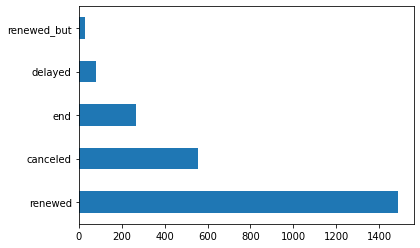

In [8]:
df_extract_most_popular_cleaning['status'].value_counts().head(20).plot.barh()

In [9]:
def clean_season_name(df):
    df_clean = df.copy()
    df_clean['season'].replace({r".*SEASON\s*(\d+).*": r"\1"}, regex=True, inplace=True)
    df_clean['season'].replace({r".*SEASONS\s*\d+\s*/\s*(\d+).*": r"\1"}, regex=True, inplace=True)
    df_clean['season'].replace({r".*S\s*(\d+).*": r"\1"}, regex=True, inplace=True)
    df_clean['season'].replace({r".*SEA[.]\s*(\d+).*": r"\1"}, regex=True, inplace=True)
    df_clean['season'].replace({r".*SN[.]\s*(\d+).*": r"\1"}, regex=True, inplace=True)
    return df_clean

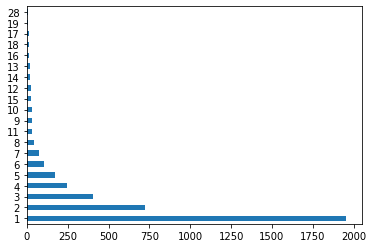

In [10]:
df_clean_season_name = clean_season_name(df_extract_most_popular_cleaning)
df_clean_season_name['season'].value_counts().head(20).plot.barh()


In [11]:
# this function returns a new df with a new 'lower_name' column, which consists of the values of the column @col_name ignoring non alpha numeric characters and converted to lower case
def add_lower_col(df, col_name):
    df_new = df.copy()
    df_new['lower_name'] = df_new[col_name].str.replace('[^a-zA-Z0-9]', '')
    df_new['lower_name'] = df_new['lower_name'].str.lower()
    return df_new

In [12]:
df_clean_season_name = add_lower_col(df_clean_season_name, 'name')

df_metacritic_grouped = df_clean_season_name[['lower_name', 'name', 'status', 'tv_network', 'changed_network', 'ano', 'season']].groupby(['lower_name'], as_index=False).agg({
    'changed_network': 'any',
    'status': 'last',
    'ano': 'last',
    'tv_network': 'last',
    'season': 'last',
    'name': 'last'
})

df_metacritic_grouped.head()
# TODO: fix status of shows which were not updated for more then 3-4 years(checking column 'ano') 
# a = df_grouped[df_grouped['ano'] < 2017]
# a[a['status'] == "renewed"]

,lower_name,changed_network,status,ano,tv_network,season,name
0,100000pyramid,False,renewed,2020,ABC,5,"$100,000 Pyramid"
1,10yearoldtom,False,NaN,2020,HBO,1,10-Year-Old Tom
2,112263,False,NaN,2015,HULU,1,11/22/63
3,12monkeys,False,end,2018,SYFY,4,12 Monkeys
4,13reasonswhy,False,end,2020,NETFLIX,4,13 Reasons Why


In [13]:
df_tvtime = add_lower_col(df_tvtime, 'name')
df_tvtime_nodup = df_tvtime[['lower_name', 'name', 'network', 'followers', 'mean_rate', 'seasons', 'number_of_seasons', 'runtime']].groupby(['lower_name'], as_index=False).apply(lambda x: x.loc[x.followers.idxmax()])

In [14]:
df_streamings = add_lower_col(df_streamings, 'Title')
df_streaming_nodup = df_streamings[['Title', 'Year', 'Age', 'Rotten Tomatoes', 'IMDb', 'lower_name']].groupby(['lower_name'], as_index=False).apply(lambda x: x.loc[x.IMDb.fillna(0).idxmax()])

In [15]:
# merge tables
df_metacritic_grouped = add_lower_col(df_metacritic_grouped, 'name')


# TODO: do something with the duplicates in df_tvtime and df_streamings
df_metacritic_tvtime = pd.merge(df_metacritic_grouped, df_tvtime_nodup, on="lower_name", how="left")
df_tv_shows = pd.merge(df_metacritic_tvtime, df_streaming_nodup, on="lower_name", how="left")

df_tv_shows = df_tv_shows[['name_x', 'changed_network', 'status', 'tv_network', 'ano', 'network', 'followers', 'mean_rate', 'seasons', 'number_of_seasons', 'runtime', 'Age', 'IMDb', 'Rotten Tomatoes', 'Year']]

# Rename some columns
df_tv_shows.rename(
    inplace=True,
    columns={
        'followers': 'tvtime_followers',
        'mean_rate': 'tvtime_rate',
        'seasons': 'no_eps_season',
        'number_of_seasons': 'no_seasons',
        'IMDb': "imdb_rate",
        "Rotten Tomatoes": "rotten_tomatoes_rate",
        "name_x": "name",
        "runtime": "eps_duration",
        "ano": "metacritc_last_info_year",
        "Year": "released_year",
        "Age": "age_rating"})


df_tv_shows['age_rating'].replace({
    r"(\d+)\+": r"\1",
    "all": "0"
}, regex=True, inplace=True)
df_tv_shows['age_rating'] = df_tv_shows['age_rating'].astype('float')
# print(df_grouped.count(), df_merge_tvtime.count(), df_merged_select.count(), sep="\n\n")

# Remove '%' from Rotten Tomatoes score
df_tv_shows['rotten_tomatoes_rate'].replace({
    r"(\d+)\%": r"\1"
}, regex=True, inplace=True)
df_tv_shows['rotten_tomatoes_rate'] = df_tv_shows['rotten_tomatoes_rate'].astype('float')
df_tv_shows.head()

#TODO: fix no_eps_season to be a value, or at least an array of ints

,name,changed_network,status,tv_network,metacritc_last_info_year,network,tvtime_followers,tvtime_rate,no_eps_season,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year
0,"$100,000 Pyramid",False,renewed,ABC,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Year-Old Tom,False,NaN,HBO,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/22/63,False,NaN,HULU,2015,NaN,NaN,NaN,NaN,NaN,NaN,18.0,8.2,80.0,2016.0
3,12 Monkeys,False,end,SYFY,2018,Syfy,242876.0,4.73,"[{'number': 1, 'nb_episodes': 13}, {'number': ...",4.0,45.0,16.0,7.7,88.0,2015.0
4,13 Reasons Why,False,end,NETFLIX,2020,Netflix,3631287.0,4.64,"[{'number': 1, 'nb_episodes': 13}, {'number': ...",3.0,60.0,18.0,7.8,39.0,2017.0


In [16]:
df_award_emmy = add_lower_col(df_award_emmy, 'nominee')
df_award_goldenglobe = add_lower_col(df_award_goldenglobe, 'nominee')
df_emmy_proc = df_award_emmy.groupby(['lower_name'], as_index=False).agg({
    'win': ['count', 'sum'],
    'nominee': 'last'
})
df_goldenglobe_proc = df_award_goldenglobe.groupby(['lower_name'],as_index=False).agg({
    'win': ['count', 'sum'],
    'nominee': 'last'
})

df_awards_joined = pd.merge(df_emmy_proc, df_goldenglobe_proc, on='lower_name', how='outer')
df_awards_joined.head()


lower_name win_x       \
                                        count  sum   
0                       100centrestreet   1.0  0.0   
1                100yearsofhopeandhumor   1.0  0.0   
2          102minutesthatchangedamerica   4.0  3.0   
3                                   105   1.0  0.0   
4  10daysthatunexpectedlychangedamerica   1.0  1.0   

                                   nominee_x win_y     nominee_y  
                                        last count sum      last  
0                          100 Centre Street   NaN NaN       NaN  
1                100 Years Of Hope And Humor   NaN NaN       NaN  
2           102 Minutes That Changed America   NaN NaN       NaN  
3                                       10.5   NaN NaN       NaN  
4  10 Days That Unexpectedly Changed America   NaN NaN       NaN

In [17]:
df_awards_count = pd.DataFrame(columns=['nominee', 'awards_won', 'awards_nominated'])
df_awards_count['nominee'] = np.where(df_awards_joined['nominee_y']['last'].isnull(), df_awards_joined['nominee_x']['last'], df_awards_joined['nominee_y']['last'])
df_awards_count['awards_nominated'] = df_awards_joined['win_x']['count'].fillna(0) + df_awards_joined['win_y']['count'].fillna(0)
df_awards_count['awards_won'] = df_awards_joined['win_x']['sum'].fillna(0) + df_awards_joined['win_y']['sum'].fillna(0)

df_awards_count.head()

,nominee,awards_won,awards_nominated
0,100 Centre Street,0.0,1.0
1,100 Years Of Hope And Humor,0.0,1.0
2,102 Minutes That Changed America,3.0,4.0
3,10.5,0.0,1.0
4,10 Days That Unexpectedly Changed America,1.0,1.0


In [18]:
#TODO salvar o nome das categorias

df_final = pd.merge(add_lower_col(df_tv_shows, 'name'), add_lower_col(df_awards_count, 'nominee'), on="lower_name", how="left")
df_final.drop(columns=["nominee", "lower_name"], inplace=True)

df_final.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,network,tvtime_followers,tvtime_rate,no_eps_season,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated
0,"$100,000 Pyramid",False,renewed,ABC,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Year-Old Tom,False,NaN,HBO,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/22/63,False,NaN,HULU,2015,NaN,NaN,NaN,NaN,NaN,NaN,18.0,8.2,80.0,2016.0,0.0,1.0
3,12 Monkeys,False,end,SYFY,2018,Syfy,242876.0,4.73,"[{'number': 1, 'nb_episodes': 13}, {'number': ...",4.0,45.0,16.0,7.7,88.0,2015.0,NaN,NaN
4,13 Reasons Why,False,end,NETFLIX,2020,Netflix,3631287.0,4.64,"[{'number': 1, 'nb_episodes': 13}, {'number': ...",3.0,60.0,18.0,7.8,39.0,2017.0,0.0,1.0


# PRE PROCESSAMENTO 1


#### Categorical Data

In [19]:
df_final_pre_proc = df_final.copy()

df_final_pre_proc.status = df_final_pre_proc.status.astype('category')
df_final_pre_proc.age_rating = df_final_pre_proc.age_rating.astype('category')

df_final_pre_proc.metacritc_last_info_year =  df_final_pre_proc.metacritc_last_info_year.astype('category')

df_final_pre_proc.awards_nominated =  df_final_pre_proc.awards_nominated.astype('category')
df_final_pre_proc.awards_won =  df_final_pre_proc.awards_won.astype('category')

df_final_pre_proc.no_seasons =  df_final_pre_proc.no_seasons.astype('category')


df_final_pre_proc.eps_duration =  df_final_pre_proc.eps_duration.astype('category')
#epi de 20 min geralmente comedia, 45/60 drama 

In [20]:
#### .cat.categories que o prof usou n sei se é IMPORTANTE 
# 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.categories.html

In [21]:
# usando info pra mostrar o memory usage diminuindo ;)))

print(df_final.info(),'\n')
print(df_final_pre_proc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      2206 non-null   object 
 1   changed_network           2206 non-null   bool   
 2   status                    1225 non-null   object 
 3   tv_network                2206 non-null   object 
 4   metacritc_last_info_year  2206 non-null   int64  
 5   network                   1375 non-null   object 
 6   tvtime_followers          1377 non-null   float64
 7   tvtime_rate               1377 non-null   float64
 8   no_eps_season             1377 non-null   object 
 9   no_seasons                1377 non-null   float64
 10  eps_duration              1377 non-null   float64
 11  age_rating                902 non-null    float64
 12  imdb_rate                 1031 non-null   float64
 13  rotten_tomatoes_rate      607 non-null    float64
 14  released

### Valores Ausentes

#### fancyimpute 
[Github](https://github.com/iskandr/fancyimpute) 

A variety of matrix completion and imputation algorithms implemented in Python 3.6.

```pip install fancyimpute```

In [22]:
from fancyimpute import KNN  ## NÃO TO CONSEGUINDO INSTALAR

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [23]:
df_final_pre_proc_knn = KNN(k=3).fit_transform(df_final_pre_proc)  # seria bom aplicar só em status 

#COMO O PROF USOU: https://github.com/ProfLuciano/cd/blob/gh-pages/notebooks/pre_processamento1.ipynb

NameError: name 'KNN' is not defined

### NORMALIZAÇÃO
[numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)



### DISCRETIZAÇÃO

[pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)

~ou qcut :: quantiles 

#  PRE PROCESSAMENTO 2

[SLIDE DO PROF](https://github.com/ProfLuciano/cd/blob/gh-pages/slides/pre_proc2.pdf)

[NOTEBOOK:)](https://github.com/ProfLuciano/cd/blob/gh-pages/notebooks/pre_processamento2.ipynb)

### DETECÇÃO DE OUTLIERS
 
 ESCOLHER UM DESSES METODOS
#### [NOTEBOOK:)](https://github.com/ProfLuciano/cd/blob/gh-pages/notebooks/pre_processamento2.ipynb) z-score robusto (univariado), metodo turkey, razão de duas variáveis (bivariado e  Elliptic Envelope

[SLIDE DO PROF: pre processamento 2](https://github.com/ProfLuciano/cd/blob/gh-pages/slides/pre_proc2.pdf)

In [24]:
df_final_pre_proc['released_year'].describe()

count    1036.000000
mean     2015.587838
std         5.868199
min      1959.000000
25%      2015.000000
50%      2017.000000
75%      2019.000000
max      2020.000000
Name: released_year, dtype: float64

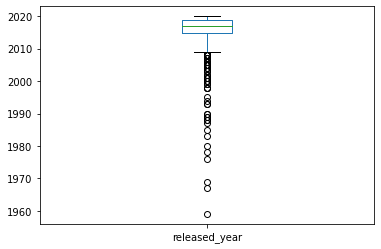

In [25]:
ax = df_final_pre_proc.released_year.plot.box() 

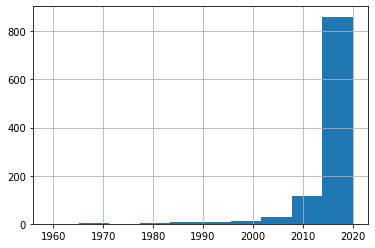

In [26]:
ax = df_final_pre_proc.released_year.hist() 

In [27]:
q1 = df_final_pre_proc.released_year.quantile(q=0.25)
q3 = df_final_pre_proc.released_year.quantile(q=0.75)
iqr = q3 - q1
print(iqr)

4.0


In [37]:

df_final_outliers_out = df_final_pre_proc[ ( df_final_pre_proc['released_year'] < (q3+1.5*iqr) ) &  ( df_final_pre_proc['released_year'] > (q3+1.5*iqr) ) ]

In [36]:
df_final_outliers_out.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,network,tvtime_followers,tvtime_rate,no_eps_season,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated


# ESTATÍSTICAS DESCRITIVAS

# TESTE DE HIPOTESE